In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('debug_diff/sqllab_sdt993_impressions_80_high_20_low_20230322T144530.csv')

In [3]:
df['query_len'] = df['query'].apply(len)

In [4]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')

/home/vscode/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [5]:
df['query_tok_len'] = df['query'].apply(lambda x: len(tokenizer('Classify query: ' + x)['input_ids']))

<AxesSubplot: ylabel='Frequency'>

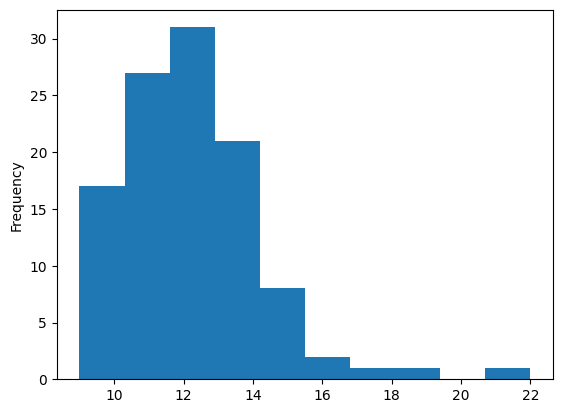

In [6]:
df.query_tok_len.plot.hist()

<AxesSubplot: ylabel='Frequency'>

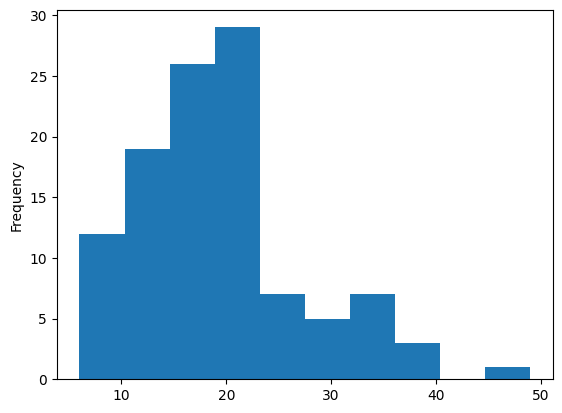

In [7]:
df.query_len.plot.hist()

In [8]:
df[df.query_tok_len <= 50]

,query,dev,stage,dev_wts,stage_wts,query_len,query_tok_len
0,maquina de neblina,"939,913,974,941,849,1210,917,5532,903,990","939,913,974,941,849,1210,917,5532,990,903","0.0999826565,0.0936938524,0.034436598400000004...","0.09998270124197006,0.0936938151717186,0.03443...",18,12
1,heron statue,"2714,2645,2661,2679,5709,5710,2655,2637,2685,2706","2714,2645,2661,2679,5709,5710,2655,2637,2685","0.8939518332,0.7741752267,0.15834936500000002,...","0.8939518332481384,0.774175226688385,0.1583494...",12,11
2,forma silicone para airfryer,"3012,3784,2930,2928,2929,2925,2947,2931,3797,2926","3012,3784,2930,2929,2928,2925,2947,2931,3797,2926","0.39402872320000004,0.3507365286,0.1482180506,...","0.3940284550189972,0.3507363796234131,0.148218...",28,13
3,warme hose herren,"4182,4181,4190,4188,4191,6031,5222,4915,4179,5207","4182,4181,4190,4188,4191,6031,5222,4915,5207,4179","0.2732402384,0.13948099320000001,0.098512575,0...","0.27324002981185913,0.1394810676574707,0.09851...",17,12
4,light fury,"3915,3925,3919,3897,3934,3974,3901,3977,3936,5709","3915,3925,3919,3897,3934,3974,3901,3977,3936,2509","0.10463726520000001,0.1025660709,0.1001786441,...","0.10463713109493256,0.10256607085466385,0.1001...",10,10
...,...,...,...,...,...,...,...
104,a3 lightbox,"1655,3925,1807,1606,1553,1626,1624,1552,516,1806","1655,3925,1807,1606,1553,1626,1624,1552,516","0.1126465723,0.061428383,0.056678447900000005,...","0.11264657974243164,0.06142842024564743,0.0566...",11,11
105,rollo steuerung,"5876,1808,2898,1579,5885,132,5191,5195,1676,106","5876,1808,2898,1579,5885,132,5195,5191,1676,106","0.0697299764,0.0533983856,0.033307299000000005...","0.0697300061583519,0.05339837446808815,0.03330...",15,12
106,writing pens for sale,"2046,2062,2082,2061,1410,2054,1887,2059,1488,2071","2046,2062,2082,2061,1410,2054,1887,1488,2059,2071","0.6720098853,0.2810544968,0.09873708340000001,...","0.6720098257064819,0.2810542583465576,0.098737...",21,11
107,boy soccer shoes,"5245,5247,5232,4380,5240,4741,5251,5385,4767,5423","5245,5247,5232,4380,5240,4741,5385,5251,4767,5423","0.9222090244000001,0.0621442907,0.0406479277,0...","0.9222090244293213,0.06214426830410957,0.04064...",16,11


In [10]:
weights_diff = []
missed_weights = []
added_weights = []
for i in df.fillna('').to_dict('records'):
    dev_wts = {}
    stage_wts = {}
    for k, v in zip(i['dev'].split(','), i['dev_wts'].split(',')):
        if len(k) > 0:
            dev_wts[k] = float(v) 
    for k, v in zip(i['stage'].split(','), i['stage_wts'].split(',')):
        if len(k) > 0:
            stage_wts[k] = float(v) 
    for k in dev_wts:
        if k in stage_wts:
            if not (-1e-4 < dev_wts[k] - stage_wts[k] < 1e-4):
                weights_diff.append(i)
                break
    for k in dev_wts:
        if k not in stage_wts:
            missed_weights.append((i, k, dev_wts[k]))
    for k in stage_wts:
        if k not in dev_wts:
            added_weights.append((i, k, stage_wts[k]))

In [12]:
len(weights_diff) ,len(missed_weights), len(added_weights)

(0, 26, 23)

In [13]:
max([i[2] for i in missed_weights])

0.0364044532

In [14]:
max([i[2] for i in added_weights])

0.03695196658372879

In [15]:
missed_weights[0]

({'query': 'heron statue',
  'dev': '2714,2645,2661,2679,5709,5710,2655,2637,2685,2706',
  'stage': '2714,2645,2661,2679,5709,5710,2655,2637,2685',
  'dev_wts': '0.8939518332,0.7741752267,0.15834936500000002,0.083498925,0.0129971635,0.0099004759,0.0090192771,0.0053493059,0.0037252039,0.0026474092',
  'stage_wts': '0.8939518332481384,0.774175226688385,0.1583494246006012,0.08349880576133728,0.0129971569404006,0.009900451637804508,0.009019260294735432,0.005349303130060434,0.003725193440914154',
  'query_len': 12,
  'query_tok_len': 11},
 '2706',
 0.0026474092)

In [17]:
all([i[0]['dev'].endswith(i[1]) for i in missed_weights])

True

In [18]:
added_weights[0]

({'query': 'light fury',
  'dev': '3915,3925,3919,3897,3934,3974,3901,3977,3936,5709',
  'stage': '3915,3925,3919,3897,3934,3974,3901,3977,3936,2509',
  'dev_wts': '0.10463726520000001,0.1025660709,0.1001786441,0.08273010700000001,0.07558809970000001,0.039496853900000004,0.0383832753,0.018651377400000002,0.0172215793,0.0164257511',
  'stage_wts': '0.10463713109493256,0.10256607085466385,0.10017862915992737,0.08273006975650787,0.07558814436197281,0.03949686512351036,0.03838331997394562,0.018651414662599564,0.017221594229340553,0.01642579585313797',
  'query_len': 10,
  'query_tok_len': 10},
 '2509',
 0.01642579585313797)

In [19]:
all([i[0]['stage'].endswith(i[1]) for i in added_weights])

True